# Analyze the visual embedding space and the semantic embedding space using given categories

In [120]:
import pickle
import pandas as pd
from pathlib2 import Path

In [121]:
embeddings_dir = Path('embeddings')
labels_dir = Path('labels')

## Define useful tools and metrics

In [122]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

In [123]:
def cluster_embeddings(embeddings_array, k):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings_array)

    # Get the cluster labels and centroids
    cluster_labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_

    return cluster_labels, cluster_centroids

In [124]:
def analyze_label_relationship(labels1, labels2):
    # Calculate the Adjusted Rand Index
    ari = adjusted_rand_score(labels1, labels2)

    # Calculate the Normalized Mutual Information
    nmi = normalized_mutual_info_score(labels1, labels2)

    # Calculate the Contingency Matrix (confusion matrix)
    cm = confusion_matrix(labels1, labels2)
    
    # Sum the maximum values of each row
    max_values_sum = np.sum(np.amax(cm, axis=1))
    
    # Calculate purity
    purity = max_values_sum / np.sum(cm)

    return ari, nmi, purity, cm


In [125]:
def tsne_plot(embeddings, labels, labels_index_dict):
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create a list of unique categories and their colors
    unique_labels = list(set(labels))
    colors = colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Plot the t-SNE
    plt.figure(figsize=(10, 8))
    for label, color in zip(unique_labels, colors):
        filter = labels == label
        plt.scatter(embeddings_2d[filter, 0], embeddings_2d[filter, 1], c=[color], label=labels_index_dict[label], s=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [126]:
def analyze(labels, embeddings):
    k = len(set(labels))
    print('Begin clustering with k =', k)
    cluster_labels, cluster_centroids = cluster_embeddings(embeddings, k)
    print('Clustering complete.')
    ari, nmi, purity, cm = analyze_label_relationship(cluster_labels, labels)
    
    random_labels = np.random.randint(0, k, len(labels))
    r_ari, r_nmi, r_purity, r_cm = analyze_label_relationship(random_labels, labels)
    
    print("Adjusted Rand Index:", ari, "random ones:", r_ari)
    print("Normalized Mutual Information:", nmi, "random ones:", r_nmi)
    print('Purity:', purity, "random ones:", r_purity)
    print("Contingency Matrix (confusion matrix):\n", cm, "\nrandom ones:\n", r_cm)
    
    print('Compare with random embeddings')
    
    return ari, nmi, purity, cm, cluster_centroids, cluster_labels
    

In [127]:
def align_labels(labels_df, embeddings):
    common_hanzi = set(labels_df['Hanzi'].values).intersection(set(embeddings.keys()))
    labels = labels_df[labels_df['Hanzi'].isin(common_hanzi)]['label_index'].values
    result_embeddings = np.array([embeddings[hanzi] for hanzi in common_hanzi])
    return labels, result_embeddings

In [128]:
def create_balanced_dataset(df, label_column, samples_per_label=None):
    """
    Creates a relatively balanced dataset by sampling a specified number of samples per label.

    :param df: A pandas DataFrame containing the data.
    :param label_column: The name of the column containing the labels.
    :param samples_per_label: The number of samples to sample per label. If None, sample all available samples.
    :return: A new DataFrame containing the balanced dataset.
    """
    unique_labels = df[label_column].unique()
    dfs = []

    for label in unique_labels:
        label_df = df[df[label_column] == label]

        if samples_per_label is not None:
            label_df = label_df.sample(min(samples_per_label, len(label_df)), random_state=42)

        dfs.append(label_df)

    # Concatenate the DataFrames and shuffle the rows
    balanced_df = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

## Analyze Visual Embeddings

In [129]:
visual_labels_df = pd.read_csv(labels_dir / 'visual_labels_cleaned.csv')
visual_labels_df.head()

,Hanzi,Structure,label_index
0,一,Unicomponent,0
1,乙,Unicomponent,0
2,二,Unicomponent,0
3,十,Unicomponent,0
4,丁,Unicomponent,0


In [130]:
visual_label_index_dict = pickle.load(open(labels_dir / 'visual_labels_index_dict.pkl', 'rb'))

### Visual embeddings

In [151]:
visual_embeddings = pickle.load(open(embeddings_dir / 'visual_embeddings.pkl', 'rb'))
visual_labels, visual_embeddings = align_labels(visual_labels_df, visual_embeddings)

In [152]:
visual_labels_df.head()

,Hanzi,Structure,label_index
0,一,Unicomponent,0
1,乙,Unicomponent,0
2,二,Unicomponent,0
3,十,Unicomponent,0
4,丁,Unicomponent,0


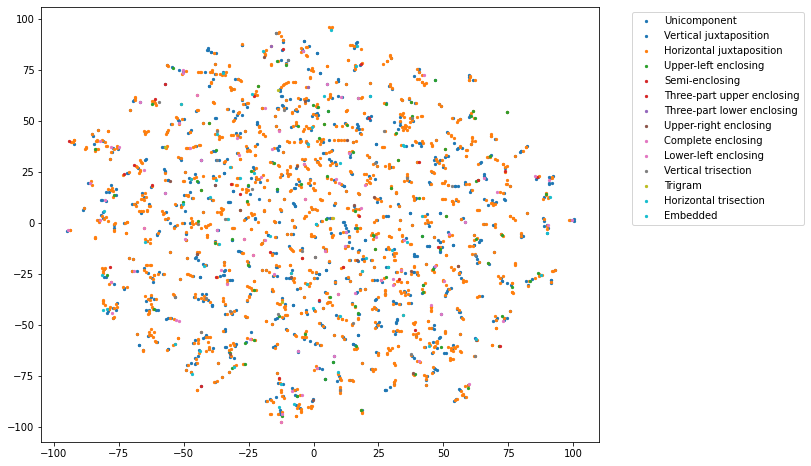

In [133]:
tsne_plot(visual_embeddings, visual_labels, visual_label_index_dict)

In [153]:
ari, nmi, purity, cm, cluster_centroids, cluster_labels = analyze(visual_labels, visual_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: 0.0015153532726590348 random ones: -0.00016218667154792638
Normalized Mutual Information: 0.014235495415760838 random ones: 0.019523418118365447
Purity: 0.5284 random ones: 0.5284
Contingency Matrix (confusion matrix):
 [[  6  34  58   5   1   0   0   1   0   1   0   0   5   0]
 [ 22  58 113   7   1   0   0   2   1   8   3   1   4   1]
 [ 13  33  63   1   0   3   0   1   1   4   1   0   3   0]
 [ 22  74 145  14   1   3   0   3   2   6   2   0   2   0]
 [ 12  35  74   6   1   1   0   1   0   5   3   0   5   0]
 [ 14  34  60   2   0   1   0   1   0   4   2   1   2   0]
 [ 25  68 117  11   0   3   0   2   1   3   3   0   1   0]
 [  2  22  36   2   0   0   0   0   0   5   2   0   2   0]
 [  7  22  59   4   0   1   0   2   2   2   2   0   2   0]
 [ 23  51 107   9   0   3   0   2   0   5   0   0   5   0]
 [ 19  46  91   8   0   2   1   0   2   2   4   1   4   0]
 [  7   9  30   2   0   0   0   1   0   4   0   0   3   0]
 

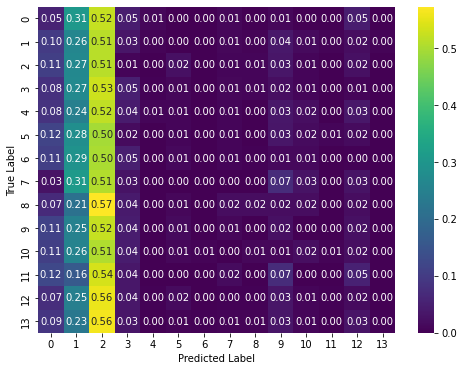

In [156]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


row_sums = cm.sum(axis=1, keepdims=True)
normalized_cm = cm / row_sums

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='viridis', fmt='.2f')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Text embeddings

In [148]:
text_embeddings = pickle.load(open(embeddings_dir / 'text_embeddings.pkl', 'rb'))
visual_labels, text_embeddings = align_labels(visual_labels_df, text_embeddings)

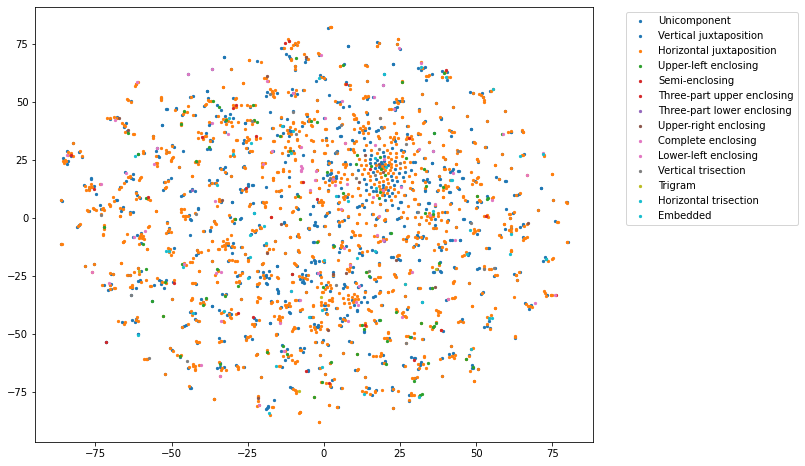

In [136]:
tsne_plot(text_embeddings, visual_labels, visual_label_index_dict)

In [150]:
ari, nmi, purity, cm, cluster_centroids, cluster_labels = analyze(visual_labels, text_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.0016865671993185074 random ones: -0.0003791743062674257
Normalized Mutual Information: 0.01771589802754773 random ones: 0.014927439405530991
Purity: 0.5284 random ones: 0.5284
Contingency Matrix (confusion matrix):
 [[  2   1   4   1   0   0   0   0   0   1   0   0   0   0]
 [ 15  30  65   5   0   0   0   0   0   3   1   1   6   0]
 [  4  20  50   0   0   3   0   0   0   2   1   0   1   0]
 [  2  18  26   1   0   0   0   0   0   1   1   1   0   0]
 [ 49 111 246  16   0   4   0   7   4  15  12   0  11   1]
 [ 12  51  82  10   0   0   0   2   1   5   1   1   3   0]
 [ 33  96 174   8   0   2   0   1   0   8   1   0   6   1]
 [ 10  27  51   6   0   2   0   2   0   1   1   0   3   0]
 [ 24  50  94   9   0   2   1   2   2   7   0   0   2   0]
 [ 11  47  87   5   0   0   1   0   0   7   1   0   1   0]
 [ 22  66 169  12   1   5   0   1   2   7   4   0   9   0]
 [ 10  37  78   7   2   2   0   2   0   4   1   1   3   0]
 [

### balanced dataset

In [138]:
# count each label
visual_labels_df['Structure'].value_counts()

Horizontal juxtaposition      1321
Vertical juxtaposition         641
Unicomponent                   226
Upper-left enclosing            93
Lower-left enclosing            70
Horizontal trisection           54
Vertical trisection             27
Three-part upper enclosing      24
Upper-right enclosing           19
Complete enclosing              12
Semi-enclosing                   5
Trigram                          4
Three-part lower enclosing       2
Embedded                         2
Name: Structure, dtype: int64

In [139]:
balanced_df = create_balanced_dataset(visual_labels_df, 'label_index', 100)
balanced_df['Structure'].value_counts()

Unicomponent                  100
Horizontal juxtaposition      100
Vertical juxtaposition        100
Upper-left enclosing           93
Lower-left enclosing           70
Horizontal trisection          54
Vertical trisection            27
Three-part upper enclosing     24
Upper-right enclosing          19
Complete enclosing             12
Semi-enclosing                  5
Trigram                         4
Embedded                        2
Three-part lower enclosing      2
Name: Structure, dtype: int64

### visual embedding (banlanced)

In [140]:
visual_embeddings = pickle.load(open(embeddings_dir / 'visual_embeddings.pkl', 'rb'))
visual_labels, visual_embeddings = align_labels(balanced_df, visual_embeddings)

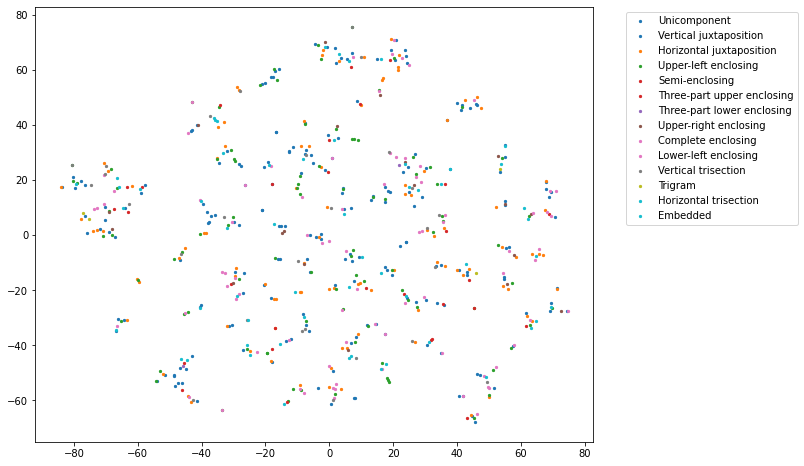

In [141]:
tsne_plot(visual_embeddings, visual_labels, visual_label_index_dict)

In [142]:
ari, nmi, purity, cm, cluster_centroids, cluster_labels = analyze(visual_labels, visual_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: 0.004525847219835182 random ones: -0.0006071437736243866
Normalized Mutual Information: 0.06334150761067898 random ones: 0.0639593295250366
Purity: 0.23202614379084968 random ones: 0.21241830065359477
Contingency Matrix (confusion matrix):
 [[ 1  7  8  5  0  2  0  0  0  4  0  0  3  0]
 [12  5 11  4  0  1  0  3  1  5  2  0  4  0]
 [14 18 22 12  1  8  1  2  1 10  1  2 12  1]
 [ 5  7  7  8  1  2  0  2  0  5  5  2  5  0]
 [ 7  6  8  6  0  2  0  1  1  2  2  0  4  0]
 [ 1  2  3  3  0  0  0  0  3  2  2  0  1  0]
 [ 1  1  2  3  0  1  0  0  1  1  0  0  2  0]
 [ 7 12  3  1  0  0  0  2  1  0  0  0  3  0]
 [ 4 10  3  7  0  0  0  1  1  5  1  0  5  0]
 [ 6  2  2  3  0  1  0  1  1  5  1  0  2  0]
 [16  5  5 13  0  1  0  1  2  5  1  0  1  1]
 [16  9 17 18  2  3  0  2  0 15  7  0  5  0]
 [ 3  7  5  7  0  1  0  2  0  6  4  0  2  0]
 [ 7  9  4  3  1  2  1  2  0  5  1  0  5  0]] 
random ones:
 [[ 7  6  8  9  0  0  1  1  1  3  5  0  5  

### Text embedding (balanced)

In [143]:
text_embeddings = pickle.load(open(embeddings_dir / 'text_embeddings.pkl', 'rb'))
visual_labels, text_embeddings = align_labels(balanced_df, text_embeddings)

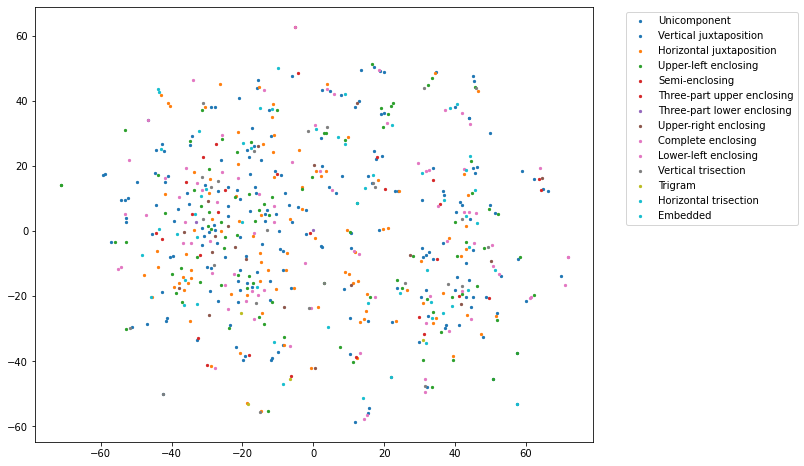

In [144]:
tsne_plot(text_embeddings, visual_labels, visual_label_index_dict)

In [146]:
ari, nmi, purity, cm, cluster_centroids, cluster_labels = analyze(visual_labels, text_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.0022242532227139894 random ones: 0.0010131881715722468
Normalized Mutual Information: 0.05531877303927577 random ones: 0.054077689869638075
Purity: 0.22712418300653595 random ones: 0.23366013071895425
Contingency Matrix (confusion matrix):
 [[10  9 20 14  1  2  0  2  2  5  4  0  6  0]
 [ 1  1  2  4  0  1  0  0  0  2  0  0  1  0]
 [ 6 17  5  6  0  2  0  2  1  7  4  1  2  0]
 [ 1  1  3  1  0  0  0  1  0  2  0  1  1  0]
 [ 0  0  1  1  0  0  0  0  0  2  0  0  0  0]
 [ 5  1  3  0  0  1  0  1  1  2  0  0  1  0]
 [ 5  5  3  6  1  1  0  0  1  1  2  0  3  0]
 [24 23 21 22  2  6  1  8  3 14  6  0 13  0]
 [ 4  1  0  2  0  0  1  1  0  4  0  0  3  0]
 [ 6  7  5  9  0  2  0  0  0  4  1  0  5  1]
 [18 10 11 15  1  1  0  2  0 12  6  0  6  0]
 [ 5  5  5  2  0  0  0  0  1  1  1  1  1  0]
 [ 2  8  7  2  0  1  0  0  0  5  0  0  3  0]
 [13 12 14  9  0  7  0  2  3  9  3  1  9  1]] 
random ones:
 [[ 7  8  8  5  1  1  0  2  2  3  2  0  